In [1]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)
dataset_path = '../datasets/surnames_by_nationality/*.txt'
print(findFiles(dataset_path))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(dataset_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Italian'][:5])


['../datasets/surnames_by_nationality/Czech.txt', '../datasets/surnames_by_nationality/German.txt', '../datasets/surnames_by_nationality/Arabic.txt', '../datasets/surnames_by_nationality/Japanese.txt', '../datasets/surnames_by_nationality/Chinese.txt', '../datasets/surnames_by_nationality/Vietnamese.txt', '../datasets/surnames_by_nationality/Russian.txt', '../datasets/surnames_by_nationality/French.txt', '../datasets/surnames_by_nationality/Irish.txt', '../datasets/surnames_by_nationality/English.txt', '../datasets/surnames_by_nationality/Spanish.txt', '../datasets/surnames_by_nationality/Greek.txt', '../datasets/surnames_by_nationality/Italian.txt', '../datasets/surnames_by_nationality/Portuguese.txt', '../datasets/surnames_by_nationality/Scottish.txt', '../datasets/surnames_by_nationality/Dutch.txt', '../datasets/surnames_by_nationality/Korean.txt', '../datasets/surnames_by_nationality/Polish.txt']
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print('Created rnn:', rnn)

Created rnn: RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [30]:
input = lineToTensor('Untrained')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8959, -2.8525, -2.9785, -2.8293, -2.8817, -2.8122, -2.9101, -2.8417,
         -2.8025, -2.9706, -2.8796, -2.9620, -2.9584, -2.8552, -2.8317, -2.8506,
         -2.9767, -2.9702]], grad_fn=<LogSoftmaxBackward0>)


In [31]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


In [29]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = French / line = Montagne
category = German / line = Laurenz
category = Vietnamese / line = Ha
category = Spanish / line = Zabala
category = Vietnamese / line = An
category = Spanish / line = Abarca
category = Irish / line = Roach
category = Japanese / line = Munakata
category = German / line = Leitner
category = Chinese / line = Seah


In [34]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [35]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 1.6475 Benivieni / Italian ✓
10000 10% (0m 4s) 1.3663 Pang / Chinese ✓
15000 15% (0m 6s) 0.5548 Lihanov / Russian ✓
20000 20% (0m 8s) 0.8910 Hanania / Arabic ✓
25000 25% (0m 10s) 0.1365 Hudonogov / Russian ✓
30000 30% (0m 12s) 3.1912 Simodines / Greek ✗ (Czech)
35000 35% (0m 14s) 0.4717 Velazquez / Spanish ✓
40000 40% (0m 16s) 1.3866 Fromm / German ✓
45000 45% (0m 19s) 1.0177 Hajjar / Arabic ✓
50000 50% (0m 21s) 0.0730 Rudawski / Polish ✓
55000 55% (0m 23s) 0.0434 Papadopulos / Greek ✓
60000 60% (0m 25s) 0.1469 Kaczka / Polish ✓
65000 65% (0m 27s) 2.6891 Tudor / Arabic ✗ (English)
70000 70% (0m 29s) 0.9582 Long / Chinese ✓
75000 75% (0m 31s) 1.4375 Maroun / Arabic ✓
80000 80% (0m 34s) 2.6967 Nazari / Italian ✗ (Arabic)
85000 85% (0m 36s) 0.2971 Deng / Chinese ✓
90000 90% (0m 38s) 1.3476 Shin / Korean ✓
95000 95% (0m 40s) 1.1319 Youn / Korean ✓
100000 100% (0m 42s) 0.0182 Katzepov / Russian ✓


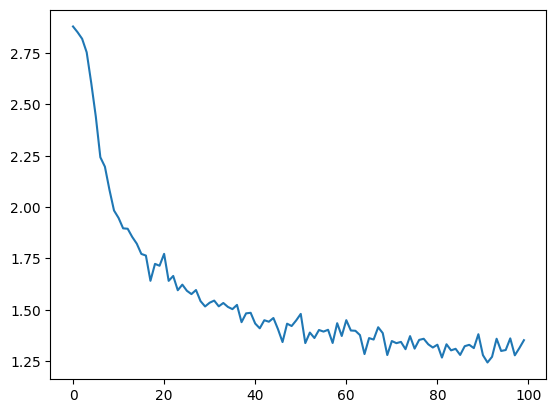

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/7f/9f_9q2ld6m3633v17rqfgd400000gn/T/ipykernel_30596/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/7f/9f_9q2ld6m3633v17rqfgd400000gn/T/ipykernel_30596/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


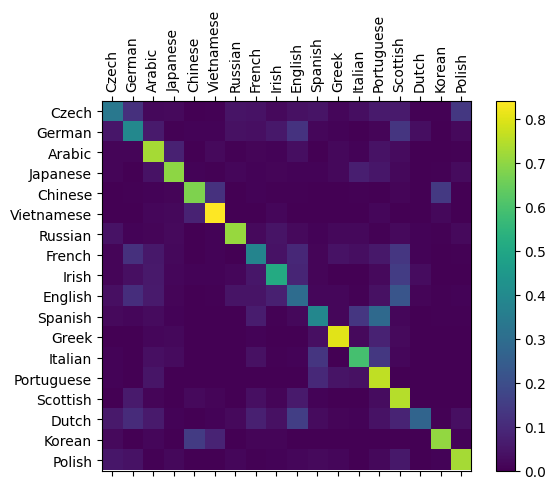

In [38]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [47]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Oleary')
predict('Frazao')
predict('Ramirez')
predict('Takahashi')


> Dovesky
(-0.64) Russian
(-0.91) Czech
(-3.51) Polish

> Jackson
(-0.74) English
(-1.16) Scottish
(-2.50) Czech

> Satoshi
(-0.33) Japanese
(-1.80) Italian
(-3.08) Arabic

> Oleary
(-0.43) Irish
(-2.18) English
(-2.89) Czech

> Frazao
(-0.14) Portuguese
(-2.59) Spanish
(-3.19) Italian

> Ramirez
(-0.56) Spanish
(-1.05) Portuguese
(-3.25) Polish

> Takahashi
(-0.00) Japanese
(-6.46) Italian
(-8.23) Russian
